This notebook creates **dataframes** from 3 different sources and names them respectively:

| Dataframe         | variable |
|:-------------------|:------------|
| charging stations | `df_ch_st` |
| registered vehicles | `df_reg_cars` |
| user charging sessions from the plugsurfing-API | `df_chr_ses` |

this notebook needs refurbishing in terms of
* commenting
* sectionizing

In [1]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

### Obtaining the dataframe for the charging stations

In [2]:

df = pd.read_excel('Ladesaeulenkarte_Datenbankauszug31.xlsx', skiprows=5)
df.drop(['Public Key1', 'Public Key2', 'Public Key3', 'Public Key4'], axis =1, inplace = True)
df.rename(columns = {'Betreiber': 'operator',
                     'Adresse' : 'address',
                     'Postleitzahl Ort' : 'zip-code',
                     'Bundesland' : 'state',
                     'Längengrad [DG]' : 'lat',
                     'Breitengrad [DG]' : 'lon',
                     'Inbetriebnahmedatum' : 'date_of_activation',
                     'Anschlussleistung [kW]' : 'charging_power',
                     'Art der Ladeeinrichtung' : 'type_of_charger',
                     'Anzahl Ladepunkte' : 'no_of_chargingpoints',
                     'Steckertypen1' : 'plugtype_1',
                     'Steckertypen2' : 'plugtype_2',
                     'Steckertypen3' : 'plugtype_3',
                     'Steckertypen4' : 'plugtype_4',
                    },
          inplace=True,            
         )
trans_dict = {'Schnellladeeinrichtung' : 'fast charger',
             'Normalladeeinrichtung' : 'normal charger',
              'Steckdose' : 'plug',
              'Typ' : 'type',
              'Kupplung' : 'connector'
             }

df['type_of_charger'] = df['type_of_charger'].apply(lambda x : trans_dict[x])

def translator(x, trans_dict):
    x = str(x)
    if not x == np.nan:
        for k, v in trans_dict.items():
            if k in x:
                x = x.replace(k, v)
    return x

df['plugtype_1'] = df['plugtype_1'].apply(lambda x : translator(x, trans_dict))
df['plugtype_2'] = df['plugtype_2'].apply(lambda x : translator(x, trans_dict))
df['plugtype_3'] = df['plugtype_3'].apply(lambda x : translator(x, trans_dict))
df['plugtype_4'] = df['plugtype_4'].apply(lambda x : translator(x, trans_dict))

df['city'] = df['zip-code'].apply(lambda x : " ".join(x.split()[1:]))
df['zip-code'] = df['zip-code'].apply(lambda x :''.join(x.split()[:1]))

cols = df.columns.tolist()
cols = cols[0:2] + cols[-1:] + cols[2:-1]
df = df[cols]

df_ch_st = df

#df.to_pickle('df_ladesaeulen.pkl')

In [3]:
df_ch_st

,operator,address,city,zip-code,state,lat,lon,date_of_activation,charging_power,type_of_charger,no_of_chargingpoints,plugtype_1,P1 [kW],plugtype_2,P2 [kW],plugtype_3,P3 [kW],plugtype_4,P4 [kW]
0,DREWAG Stadtwerke Dresden GmbH,Ammonstraße 72,Dresden,01067,Sachsen,13.721480,51.048719,2019-11-26,175,fast charger,2,"DC connector Combo, DC CHAdeMO",150,AC plug type 2,22,nan,NaN,nan,NaN
1,Autohaus Melkus GmbH,Hamburger Straße 30,Dresden,01067,Sachsen,13.698890,51.059870,2019-01-28,44,normal charger,2,AC plug type 2,22,AC plug type 2,22,nan,NaN,nan,NaN
2,DREWAG Stadtwerke Dresden GmbH,Magdeburger Straße 12,Dresden,01067,Sachsen,13.720513,51.062423,2019-11-18,33,normal charger,4,AC plug type 2,22,AC Schuko,3.7,AC plug type 2,22.0,AC Schuko,3.7
3,DREWAG Stadtwerke Dresden GmbH,Ringstraße 0,Dresden,01067,Sachsen,13.744003,51.048741,2018-10-30,150,fast charger,1,"DC connector Combo, DC CHAdeMO",75,nan,NaN,nan,NaN,nan,NaN
4,DREWAG Stadtwerke Dresden GmbH,Ringstraße 0,Dresden,01067,Sachsen,13.743981,51.048716,2020-02-26,175,fast charger,2,"DC connector Combo, DC CHAdeMO",150,AC plug type 2,22,nan,NaN,nan,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13546,Stadtwerke Mühlhausen GmbH,Windeberger Landstr. 73,Mühlhausen,99974,Thüringen,10.472140,51.223090,2012-06-01,22,normal charger,2,"AC plug type 2, AC Schuko",22,"AC plug type 2, AC Schuko",22,nan,NaN,nan,NaN
13547,Thüringer Energie AG,Gedeplatz,Lengenfeld unterm Stein,99976,Thüringen,10.219470,51.214110,2017-10-25,30,normal charger,2,AC plug type 2,22,AC plug type 2,22,nan,NaN,nan,NaN
13548,Thüringer Energie AG,Karlstraße 26,Heyerode,99988,Thüringen,10.313755,51.164651,2017-10-25,30,normal charger,2,AC plug type 2,22,AC plug type 2,22,nan,NaN,nan,NaN
13549,Thüringer Energie AG,Hauptstraße 46,Altengottern,99991,Thüringen,10.586071,51.163845,2019-04-24,30,normal charger,2,AC plug type 2,22,AC plug type 2,22,nan,NaN,nan,NaN


### Obtaining the dataframe for the yearly newly registered vehicles (including electric)

In [4]:
url="https://www.kba.de/DE/Statistik/Fahrzeuge/Neuzulassungen/Umwelt/n_umwelt_z.html"
    
import pandas as pd
import requests

r = requests.get(url)
df_list = pd.read_html(r.text,
                       decimal=',',
                       thousands='.',
                      )
df = pd.DataFrame(df_list[0])
df['Jahr'] = pd.to_datetime(df['Jahr'], format="%Y")
col_names = df.columns.to_list()
engl_cols = ['year',
             'gasoline',
             'diesel',
             'liquid_gas',
             'natural_gas',
             'electric',
             'hybrid_total',
             'plug_in_of_hybrid',
             'total',
            ]
df= df.rename(columns={k:v for k,v in zip(col_names,engl_cols)})

df['plug_in_of_hybrid'] = df['plug_in_of_hybrid'].apply(lambda x: int(x) if x.isnumeric() else np.nan)
df_reg_cars = df
df_reg_cars

,year,gasoline,diesel,liquid_gas,natural_gas,electric,hybrid_total,plug_in_of_hybrid,total
0,2009-01-01,2608767,1168633,11083,10062,162,8374,NaN,3807175
1,2010-01-01,1669927,1221938,8154,4982,541,10661,NaN,2916260
2,2011-01-01,1651637,1495966,4873,6283,2154,12622,NaN,3173634
3,2012-01-01,1555241,1486119,11465,5215,2956,21438,408.0,3082504
4,2013-01-01,1502784,1403113,6257,7835,6051,26348,1385.0,2952431
5,2014-01-01,1533726,1452565,6234,8194,8522,27435,4527.0,3036773
6,2015-01-01,1611389,1538451,4716,5285,12363,33630,11101.0,3206042
7,2016-01-01,1746308,1539596,2990,3240,11410,47996,13744.0,3351607
8,2017-01-01,1986488,1336776,4400,3723,25056,84675,29436.0,3441262
9,2018-01-01,2142700,1111130,4663,10804,36062,130258,31442.0,3435778


# Obtaining the dataframe for electric vehicle charging sessions

In [5]:
response = requests.get("https://api.plugsurfing.com/mfund/stations")
results=response.json()
data = pd.DataFrame(results)

connectors_into_df = pd.concat([pd.DataFrame(x) for x in data['connectors']], keys=data[:]).reset_index(level=1, drop=True).reset_index()

connectors_list = connectors_into_df.values.tolist()

### Extracting 'vehicleUsage_df' from 'sessions' API 

In [6]:
response = requests.get("https://api.plugsurfing.com/mfund/sessions")
sessions_data=response.json()

vehicleUsage_dict = sessions_data['vehicleUsage']

vehicleUsage_df=pd.DataFrame(vehicleUsage_dict)

#change column 'name' to "type-of-cars" and "percentage" to "usage coefficient"
vehicleUsage_df = vehicleUsage_df.rename(columns={'name':'type-of-cars', 'percentage':'usage-coefficient'})

vehicleUsage_df.sort_values("usage-coefficient", ascending=False).reset_index(drop=True)

#pickle
vehicleUsage_df.to_pickle('vehicleUsage_pickle.pkl')

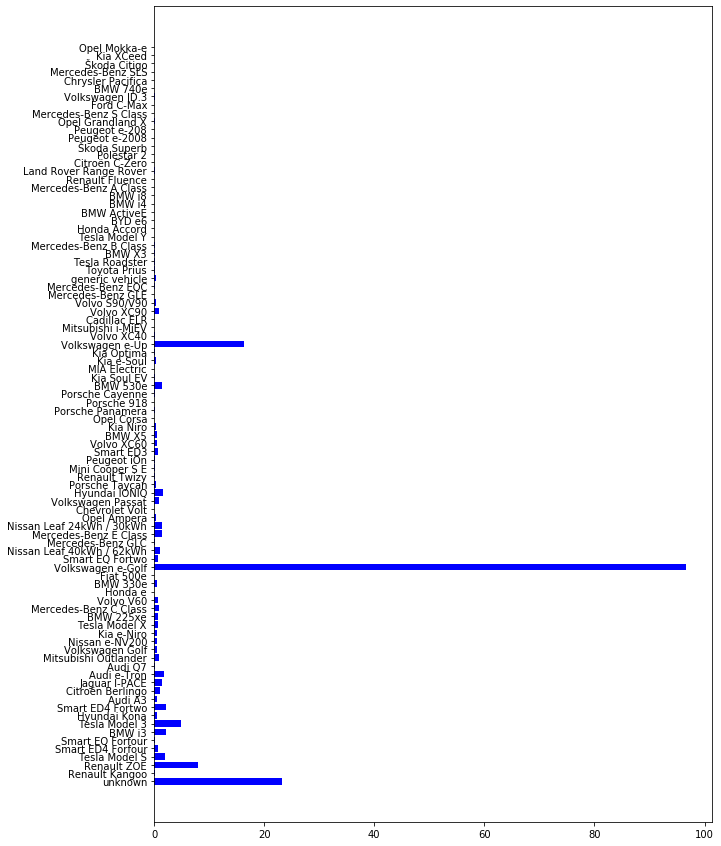

In [7]:
fig, ax = plt.subplots(figsize=(10,15))
plt.barh(vehicleUsage_df["type-of-cars"],
       vehicleUsage_df["usage-coefficient"],
       color = "blue");

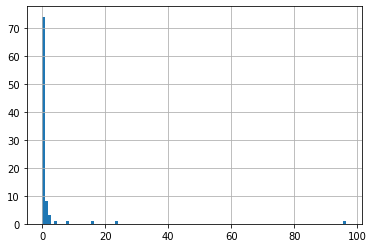

In [8]:
vehicleUsage_df['usage-coefficient'].hist(bins=100)

## Plotting from two different databases

In [11]:
df_reg_cars['diff_to_prev_year_electric'] = df_reg_cars.diff(axis=0)['electric']

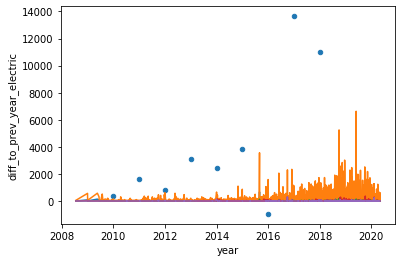

In [15]:
df_reg_cars.plot(x='year', y='diff_to_prev_year_electric', kind='scatter')
plt.plot(df_ch_st.groupby('date_of_activation').sum())

In [13]:
df_ch_st.head()

,operator,address,city,zip-code,state,lat,lon,date_of_activation,charging_power,type_of_charger,no_of_chargingpoints,plugtype_1,P1 [kW],plugtype_2,P2 [kW],plugtype_3,P3 [kW],plugtype_4,P4 [kW]
0,DREWAG Stadtwerke Dresden GmbH,Ammonstraße 72,Dresden,01067,Sachsen,13.721480,51.048719,2019-11-26,175,fast charger,2,"DC connector Combo, DC CHAdeMO",150,AC plug type 2,22,nan,NaN,nan,NaN
1,Autohaus Melkus GmbH,Hamburger Straße 30,Dresden,01067,Sachsen,13.698890,51.059870,2019-01-28,44,normal charger,2,AC plug type 2,22,AC plug type 2,22,nan,NaN,nan,NaN
2,DREWAG Stadtwerke Dresden GmbH,Magdeburger Straße 12,Dresden,01067,Sachsen,13.720513,51.062423,2019-11-18,33,normal charger,4,AC plug type 2,22,AC Schuko,3.7,AC plug type 2,22.0,AC Schuko,3.7
3,DREWAG Stadtwerke Dresden GmbH,Ringstraße 0,Dresden,01067,Sachsen,13.744003,51.048741,2018-10-30,150,fast charger,1,"DC connector Combo, DC CHAdeMO",75,nan,NaN,nan,NaN,nan,NaN
4,DREWAG Stadtwerke Dresden GmbH,Ringstraße 0,Dresden,01067,Sachsen,13.743981,51.048716,2020-02-26,175,fast charger,2,"DC connector Combo, DC CHAdeMO",150,AC plug type 2,22,nan,NaN,nan,NaN
